<a href="https://colab.research.google.com/github/csgm2328/Emily/blob/master/LSTM_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import

In [27]:
!nvidia-smi 

Tue Nov  3 10:08:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    28W /  70W |    617MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as pdr #data 받아오는 api 라이브러리
from pandas import json_normalize
import numpy as np
import plotly as py
import plotly.graph_objs as go
import requests
from datetime import datetime
import traceback
import os
from keras import metrics
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from pandas.util.testing import assert_frame_equal
from sklearn.preprocessing import MinMaxScaler

plt.style.use('bmh')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



#Request URL API

In [2]:
#all stock list from KRX
stock_url = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0] 
stock_url.종목코드 = stock_url.종목코드.map('{:06d}'.format)
stock_url = stock_url[['회사명', '종목코드']] 
stock_url = stock_url.rename(columns={'회사명':'name', '종목코드':'code'})

In [4]:
# 원하는 종목 이름 입력 ex) 'BTC' or 'NH투자증권'
item_name = 'BTC' 

# 데이터 범위
start = (2012, 1, 1)
start_date = datetime(*start)
end = datetime.today()

In [5]:
if item_name == 'BTC': #BTC는 poloniex.co.kr
  start = int(start_date.timestamp()) #USDT_BTC는 (2015, 2, 19) 부터 data 있음
  period = 86400 # 24h
  #300, 900, 1800, 7200, 14400, and 86400.
  
  ret = requests.get('https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start={}&end=9999999999&period={}'.format(start, period)) #Crawling
  print(ret)

  js = ret.json()
  #print(js[-1])
  df = pd.DataFrame(js)
  
  df.set_index(df['date'],inplace=True) #date를 index로, inplace 는 결과반영여부
  df.drop(['date', 'quoteVolume'],axis = 'columns', inplace=True) # quoteVolume은 거래대상통화(xrp) 단위의 해당 tic 거래량 
  df.rename(columns={'close':'Close'},inplace=True) #BTC는 columns 소문자
  
  #int to datetype
  as_list = df.index.tolist()
  for i in range(len(as_list)):
    as_list[i] = datetime.fromtimestamp(as_list[i]).strftime('%Y-%m-%d')
  df.index = as_list

  item_name += '_USD'
  print(item_name)

else: # Stock은 finance.naver.com
  code = stock_url.query("name=='{}'".format(item_name))['code'].to_string(index=False).strip() #strip 앞뒤공백제거
  #DataReader용
  df = pdr.DataReader(code, 'naver', start_date, end) #Crawling
  print(item_name, code)
 
df

<Response [200]>
BTC_USD


,high,low,open,Close,volume,weightedAverage
2015-02-19,244.00000,225.000000,225.000000,244.000000,4.627631e+01,239.627778
2015-02-20,245.00000,240.250000,240.250118,240.250000,5.589490e+01,242.568479
2015-02-21,245.00000,245.000000,245.000000,245.000000,1.472224e+01,245.000000
2015-02-22,249.00000,235.000000,245.000000,235.000000,1.291212e+02,239.532608
2015-02-23,235.00100,235.000000,235.000002,235.000000,9.656756e+01,235.000062
...,...,...,...,...,...,...
2020-11-02,13825.00000,13207.512939,13750.000000,13558.843014,1.948272e+07,13507.520272
2020-11-03,14046.57680,13287.613912,13556.055537,14014.593955,1.743273e+07,13631.217474
2020-11-04,14240.00000,13532.193982,14014.593955,14133.455221,1.950400e+07,13909.413967
2020-11-05,15740.00000,14092.323718,14143.701038,15586.953494,3.825392e+07,14820.435737


In [6]:
# 데이터 정규화
# 0~1 범위로 정규화함으로써 최적화 알고리즘에서 오차를 줄여 최적값에 빨리 도달하게 해 학습속도를 높인다
scaler = MinMaxScaler()
real_price = df['Close'].tolist()
price = scaler.fit_transform(df[['Close']]).reshape(-1).tolist()
print('오늘은', end, real_price[-1], len(real_price), '개')

오늘은 2020-11-06 14:03:03.456289 15631.49599303 2088 개


#Hyper Parameter

In [7]:
from keras import optimizers
#args
n_Memcell = 128
window_size = 60 #학습단위 ex) 10일 예측해서 그 다음날 예측
b_state = True
predict_day = 10
#return_sequences = 여러 층일때, 각 시퀀스에서 출력할지 말지 결정. many to many 일때

n_batch = 1
n_epoch =  10#colab 12시간 제한 특성 때문
n_drop = 0.2
learning_rate = 0.001 #default
ac_func = 'relu'
loss_func = 'mse'
optim_func = optimizers.Adam(lr=learning_rate)
#decay_rate = 0.001 #신경망에서는 수학적으로 동일한 L2 놈을 대신사용한다.
#optim_func = optimizers.Adadelta(learning_rate = learning_rate) #0.1, 0.001 둘다 과소적합

args_str = '['+str(datetime.date(start_date)) + ' ~ ' + str(datetime.date(datetime.today())) + '] ' + str(n_Memcell) + 'cell '+ str(window_size) +'win '+ str(n_batch) +'bat ' + str(n_epoch) + 'ep '+ str(n_drop) + 'drop ' + str(b_state) + ' ' + str(learning_rate) + 'lr'
Title = item_name + ': ' + args_str
Title

'BTC_USD: [2012-01-01 ~ 2020-11-06] 128cell 60win 1bat 10ep 0.2drop True 0.001lr'

#make DataSet

In [8]:
x = []  #window_size 데이터를 하나빼고 겹치게 가지는 훈련집합 (특징벡터 - 훈련집합)
y = []  #window_size + 1(다음날)의 데이터를 가지는 목적집합 (결과값 - 훈련집합)

for i in range(len(price) - window_size):   
    x.append([price[i+j] for j in range(window_size)])
    y.append(price[window_size + i])
  

In [9]:
x = np.asarray(x)
y = np.asarray(y)
print(x.shape)
print(type(y))

(2028, 60)
<class 'numpy.ndarray'>


In [10]:
train_test_split = int(len(x)*0.3) #train과 test set 스왑
#최근의 데이터를 학습하고
#예전의 데이터로 일반화 test.
#이로써 미래 예측에 좀 더 유리해진다

split_pt = train_test_split + window_size

x_test = x[:train_test_split, :]
y_test = y[:train_test_split]

x_train = x[train_test_split:, :]
y_train = y[train_test_split:]

xtrain = x_train.reshape((x_train.shape[0], x_train.shape[1], 1)) # 2차원 데이터 3차원화, LSTM의 데이터 생성할때 주의해야하는 포인트, [sequence,  time_step , input_dim]
xtest =  np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  #test 집합을 늘리면 미래를 예측할 수 있을까?

print(xtrain.shape)
print(x_test.shape) 

(1420, 60, 1)
(608, 60)


In [11]:
#history Metrics
import keras
class CustomHistory(keras.callbacks.Callback):
  def init(self):
    self.losses = []
    self.accs = []
  def on_epoch_end(self, batch, logs={}):
    self.losses.append(logs.get('loss'))
    self.accs.append(logs.get('acc'))   

# Model Define & Training

In [12]:
#Model Define
model = Sequential()
model.add(LSTM(n_Memcell, batch_input_shape =(n_batch, window_size, 1), stateful=b_state)) # 상태유지
model.add(Dropout(n_drop)) # overfitting 방지
#model.add(Activation(ac_func))
model.add(Dense(1)) # Output layer

model.compile(loss=loss_func, optimizer=optim_func, metrics=['mae', 'acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 128)                  66560     
_________________________________________________________________
dropout (Dropout)            (1, 128)                  0         
_________________________________________________________________
dense (Dense)                (1, 1)                    129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [13]:
%%time
report = CustomHistory()
report.init()
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=10, mode='auto') #overfitting을 피하기위한 훈련종료 포인트 지정

for i in range(n_epoch):
    print('[%d] ' %i)
    model.fit(xtrain, y_train, epochs=1, batch_size=n_batch, callbacks=[report, early_stopping],verbose=2)
    model.reset_states()



[0] 
1420/1420 - 5s - loss: 0.0031 - mae: 0.0374 - acc: 7.0423e-04
[1] 
1420/1420 - 5s - loss: 0.0017 - mae: 0.0285 - acc: 7.0423e-04
[2] 
1420/1420 - 5s - loss: 0.0012 - mae: 0.0252 - acc: 7.0423e-04
[3] 
1420/1420 - 5s - loss: 0.0012 - mae: 0.0236 - acc: 7.0423e-04
[4] 
1420/1420 - 5s - loss: 9.4582e-04 - mae: 0.0218 - acc: 7.0423e-04
[5] 
1420/1420 - 5s - loss: 9.2628e-04 - mae: 0.0213 - acc: 7.0423e-04
[6] 
1420/1420 - 5s - loss: 8.2806e-04 - mae: 0.0201 - acc: 7.0423e-04
[7] 
1420/1420 - 5s - loss: 7.8901e-04 - mae: 0.0201 - acc: 7.0423e-04
[8] 
1420/1420 - 5s - loss: 7.3790e-04 - mae: 0.0189 - acc: 7.0423e-04
[9] 
1420/1420 - 5s - loss: 7.5932e-04 - mae: 0.0194 - acc: 7.0423e-04
CPU times: user 1min, sys: 5.45 s, total: 1min 5s
Wall time: 57.8 s


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
cd /content/drive/My Drive/Colab Notebooks/LSTM_models

/content/drive/My Drive/Colab Notebooks/LSTM_models


In [42]:
#Model Save
from keras.models import load_model
model.save(Title + '.h5')

#Evaluate

In [43]:
trainScore = model.evaluate(xtrain, y_train, batch_size=n_batch, verbose=0)
testScore = model.evaluate(xtest, y_test, batch_size=n_batch, verbose=0)
print("mae: (%.5f, %.5f)" %(trainScore[1], testScore[1]))

mae: (0.01367, 0.00654)


In [44]:
print(trainScore)
testScore

[0.0003524522471707314, 0.013665372505784035, 0.0007052186410874128]


[4.373166666482575e-05, 0.0065358709543943405, 0.0016474464209750295]

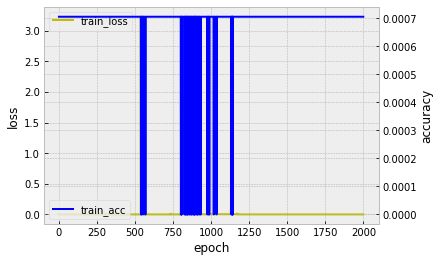

In [45]:
loss_ax = plt.subplot()
acc_ax = loss_ax.twinx()

loss_ax.plot(report.losses, 'y', label='train_loss')
acc_ax.plot(report.accs, 'b', label='train_acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# Prediction

In [46]:
#train, test prediction
train_pred = model.predict(xtrain,batch_size=n_batch) # x[0~window_size-1] 만큼의 특징벡터를 학습해서 학습데이터 수 
model.reset_states() #상태 리셋해주지 않으면 predcit마다 값이 다름
test_pred = model.predict(xtest,batch_size=n_batch)
model.reset_states()
real_test_pred = scaler.inverse_transform(test_pred)

In [47]:
tom_real = xtrain[-1]
tom_real = np.vstack((tom_real[1:], price[-1])) #test_pred[-1] 대신에 price[-1]
tom_real.shape

tom_pred = xtest[-1]
tom_pred = np.vstack((tom_pred[1:], test_pred[-1])) #마지막 데이터에 예측값
tom_pred.shape

(60, 1)

In [48]:
#학습된 모델로 예측하기
seq_in = tom_real #오늘꺼 예측자를 마지막 데이터로 추가해준 input 샘플 or real 데이터 추가
after_pred = np.zeros((predict_day,1))

for i in range(predict_day):
  sample_in = seq_in.reshape(1,window_size,1)
  after = model.predict(sample_in, batch_size=n_batch)
  model.reset_states()
  seq_in = np.vstack((seq_in[1:], after))
  after_pred[i] = after
  
#model.reset_states()
real_after_pred = scaler.inverse_transform(after_pred)

# Result

In [50]:
trace = go.Scatter(x=np.arange(0,len(price),1), y=price, 
mode = 'lines', name='actual')
trace2 = go.Scatter(x=np.arange(window_size,split_pt,1), y=test_pred.reshape(len(test_pred)),
mode = 'lines', name='train')
trace3 = go.Scatter(x=np.arange(split_pt,split_pt + len(train_pred),1), y=train_pred.reshape(len(train_pred)), 
mode = 'lines', name='prediction')
trace4 = go.Scatter(x=np.arange(split_pt +len(train_pred), split_pt + len(train_pred) + len(after_pred), 1), y =after_pred.reshape(len(after_pred)),
mode = 'lines', name= 'after_pred')

data = [trace, trace2, trace3, trace4]
layout = go.Layout(title=Title)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig) #그래프 출력 
#py.offline.plot(fig, show_link = True, filename = Title + '.html') #다른이름으로 지정

from google.colab import files
import os

#os.rename('temp-plot.html', rename)
#files.download(filename=Title +'.html') #다운로드

In [51]:
print('현재 종가: ', real_price[-1], 
      '\n다음 예측가격: \n', real_after_pred.astype(int))

현재 종가:  13541.54827093 
다음 예측가격: 
 [[13634]
 [13736]
 [13722]
 [13876]
 [13863]
 [13850]
 [13804]
 [13741]
 [13831]
 [13712]]


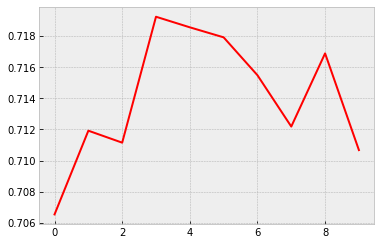

In [52]:
plt.plot(np.arange(0,len(after_pred), 1), after_pred, color='red')